## spark-ts Matrices


In [1]:
cp /Users/rangelg/Desktop/fred_timeseries/jupyter_notebooks/__fred_timeseries_allignment.ipynb .

In [1]:
from datetime import datetime

from pyspark import SparkContext, SQLContext
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, TimestampType, DoubleType, StringType

from sparkts.datetimeindex import uniform, BusinessDayFrequency
from sparkts.timeseriesrdd import time_series_rdd_from_observations

def lineToRow(line):
    (year, month, day, symbol, volume, price) = line.split("\t")
    # Python 2.x compatible timestamp generation
    dt = datetime(int(year), int(month), int(day))
    return (dt, symbol, float(price))

def loadObservations(sparkContext, sqlContext, path):
    textFile = sparkContext.textFile(path)
    rowRdd = textFile.map(lineToRow)
    schema = StructType([
        StructField('timestamp', TimestampType(), nullable=True),
        StructField('symbol', StringType(), nullable=True),
        StructField('price', DoubleType(), nullable=True),
    ])
    return sqlContext.createDataFrame(rowRdd, schema);

In [2]:
!wget https://raw.githubusercontent.com/sryza/spark-ts-examples/master/data/ticker.tsv

--2016-10-14 15:56:36--  https://raw.githubusercontent.com/sryza/spark-ts-examples/master/data/ticker.tsv
Resolving raw.githubusercontent.com... 151.101.44.133
Connecting to raw.githubusercontent.com|151.101.44.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105146 (103K) [text/plain]
Saving to: 'ticker.tsv.4'

ticker.tsv.4        100%[===================>] 102.68K   197KB/s    in 0.5s    

2016-10-14 15:56:38 (197 KB/s) - 'ticker.tsv.4' saved [105146/105146]



In [3]:
tickerObs = loadObservations(sc, sqlContext, "ticker.tsv")

In [4]:
tickerObs.show(2, truncate=False)

+---------------------+------+------+
|timestamp            |symbol|price |
+---------------------+------+------+
|2015-08-14 00:00:00.0|ADP   |82.99 |
|2015-09-14 00:00:00.0|NKE   |111.78|
+---------------------+------+------+
only showing top 2 rows



In [5]:
# Create an daily DateTimeIndex over August and September 2015
freq = BusinessDayFrequency(1, 1, sc)
dtIndex = uniform(start='2015-08-03T00:00+01:00', end='2015-09-22T00:00+01:00', freq=freq, sc=sc)

In [6]:
dtIndex

uniform,Europe/London,2015-08-03T00:00+01:00[Europe/London],37,businessDays 1 firstDayOfWeek 1

In [7]:
tickerTsrdd = time_series_rdd_from_observations(dtIndex, tickerObs, "timestamp", "symbol", "price")

In [8]:
tickerTsrdd.take(20)

[(u'AAL',
  array([ 41.71,  42.74,  42.96,  42.18,  41.49,  41.68,  42.7 ,  42.52,
          42.67,  42.88,  43.95,  43.63,  43.53,  41.98,  39.75,  37.62,
          37.5 ,  38.85,  39.03,  38.62,  38.98,  39.2 ,  41.51,  40.89,
          40.6 ,    nan,  40.8 ,  41.  ,  41.21,  42.15,  42.29,  42.64,
          43.06,  43.99,  43.49,  43.24,  41.19])),
 (u'AAPL',
  array([ 118.44  ,  114.64  ,  115.4   ,  115.13  ,  115.52  ,  119.6901,
          113.5499,  115.24  ,  115.15  ,  116.    ,  117.1601,  116.5   ,
          115.01  ,  112.65  ,  105.76  ,  103.155 ,  103.74  ,  109.625 ,
          112.92  ,  113.29  ,  112.76  ,  107.72  ,  112.34  ,  110.37  ,
          109.27  ,       nan,  112.21  ,  110.15  ,  112.57  ,  114.017 ,
          115.3   ,  116.28  ,  116.35  ,  113.92  ,  113.45  ,  115.23  ,
          113.432 ])),
 (u'ADI',
  array([ 58.67,  58.48,  60.7 ,  58.87,  59.61,  61.09,  59.38,  59.74,
          59.  ,  58.84,  59.5 ,  57.9 ,  58.38,  53.82,  53.78,  51.67,
      

In [9]:
tickerTsrdd.cache()

# Count the number of series (number of symbols)
print(tickerTsrdd.count())

# Impute missing values using linear interpolation
filled = tickerTsrdd.fill("linear")

# Compute return rates
returnRates = filled.return_rates()

# Durbin-Watson test for serial correlation, ported from TimeSeriesStatisticalTests.scala
def dwtest(residuals):
    residsSum = residuals[0] * residuals[0]
    diffsSum = 0.0
    i = 1
    while i < len(residuals):
        residsSum += residuals[i] * residuals[i]
        diff = residuals[i] - residuals[i - 1]
        diffsSum += diff * diff
        i += 1
    return diffsSum / residsSum

# Compute Durbin-Watson stats for each series
# Swap ticker symbol and stats so min and max compare the statistic value, not the
# ticker names.
dwStats = returnRates.map_series(lambda row: (row[0], [dwtest(row[1])])).map(lambda x: (x[1], x[0]))

print(dwStats.min())
print(dwStats.max())

104
([0.99930539174187916], u'NFLX')
([2.3701164736953166], u'DISCK')


In [97]:
returnRates.take(2)

[(u'AAL',
  array([ 0.02469432,  0.0051474 , -0.01815642, -0.01635846,  0.00457942,
          0.02447217, -0.00421546,  0.00352775,  0.00492149,  0.02495336,
         -0.007281  , -0.002292  , -0.03560763, -0.05312053, -0.05358491,
         -0.00318979,  0.036     ,  0.0046332 , -0.01050474,  0.0093216 ,
          0.00564392,  0.05892857, -0.01493616, -0.0070922 ,  0.00246305,
          0.002457  ,  0.00490196,  0.00512195,  0.02281   ,  0.00332147,
          0.00827619,  0.00984991,  0.02159777, -0.01136622, -0.00574845,
         -0.04740981])),
 (u'AAPL',
  array([-0.03208376,  0.00662945, -0.00233969,  0.00338748,  0.03609851,
         -0.05130082,  0.01488421, -0.00078098,  0.00738168,  0.01000086,
         -0.00563417, -0.0127897 , -0.02051995, -0.06116289, -0.02463124,
          0.00567108,  0.05672836,  0.03005701,  0.00327666, -0.00467826,
         -0.0446967 ,  0.04288897, -0.01753605, -0.00996648,  0.01345291,
          0.01327434, -0.01835844,  0.02197004,  0.01285422,  0.01

In [10]:
tickerTsrdd.take(2)

[(u'AAL',
  array([ 41.71,  42.74,  42.96,  42.18,  41.49,  41.68,  42.7 ,  42.52,
          42.67,  42.88,  43.95,  43.63,  43.53,  41.98,  39.75,  37.62,
          37.5 ,  38.85,  39.03,  38.62,  38.98,  39.2 ,  41.51,  40.89,
          40.6 ,    nan,  40.8 ,  41.  ,  41.21,  42.15,  42.29,  42.64,
          43.06,  43.99,  43.49,  43.24,  41.19])),
 (u'AAPL',
  array([ 118.44  ,  114.64  ,  115.4   ,  115.13  ,  115.52  ,  119.6901,
          113.5499,  115.24  ,  115.15  ,  116.    ,  117.1601,  116.5   ,
          115.01  ,  112.65  ,  105.76  ,  103.155 ,  103.74  ,  109.625 ,
          112.92  ,  113.29  ,  112.76  ,  107.72  ,  112.34  ,  110.37  ,
          109.27  ,       nan,  112.21  ,  110.15  ,  112.57  ,  114.017 ,
          115.3   ,  116.28  ,  116.35  ,  113.92  ,  113.45  ,  115.23  ,
          113.432 ]))]

In [99]:
from sparkts.models import ARIMA

for ts in 
model = returnRates.map_series(lambda row: (row[0], [dwtest(row[1])])).map(lambda x: (x[1], x[0]))
arimaModel = ARIMA.fitModel(1, 0, 1, ts)

In [102]:
arimaModel = ARIMA.fit_model(1, 0, 1, tickerTsrdd)

In [129]:
returnRates.collect()[0][1]

array([ 0.02469432,  0.0051474 , -0.01815642, -0.01635846,  0.00457942,
        0.02447217, -0.00421546,  0.00352775,  0.00492149,  0.02495336,
       -0.007281  , -0.002292  , -0.03560763, -0.05312053, -0.05358491,
       -0.00318979,  0.036     ,  0.0046332 , -0.01050474,  0.0093216 ,
        0.00564392,  0.05892857, -0.01493616, -0.0070922 ,  0.00246305,
        0.002457  ,  0.00490196,  0.00512195,  0.02281   ,  0.00332147,
        0.00827619,  0.00984991,  0.02159777, -0.01136622, -0.00574845,
       -0.04740981])

In [130]:
from pyspark.mllib.linalg import Vectors

In [131]:
ts = Vectors.dense(returnRates.collect()[0][1])

In [135]:
m = ARIMA.fit_model(1,0,1,ts, sc=sc) 

In [136]:
m.coefficients

[-0.0012474547399206936, 0.2666755318221923, 0.0961795619837402]

In [137]:
forecast = m.forecast(ts, 20)

In [140]:
%matplotlib inline

In [142]:
import matplotlib.pyplot as plt

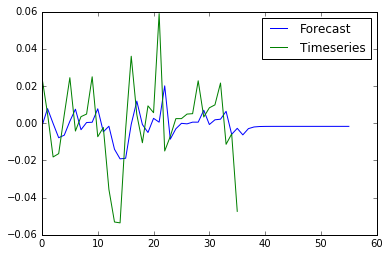

In [157]:
plt.plot(forecast.toArray(), label="Forecast")
plt.plot(ts.toArray(), label="Timeseries")
plt.legend(loc="best")



In [152]:
dwStats.collect()

[(u'AAL',
  DenseVector([0.0247, 0.0051, -0.0182, -0.0164, 0.0046, 0.0245, -0.0042, 0.0035, 0.0049, 0.025, -0.0073, -0.0023, -0.0356, -0.0531, -0.0536, -0.0032, 0.036, 0.0046, -0.0105, 0.0093, 0.0056, 0.0589, -0.0149, -0.0071, 0.0025, 0.0025, 0.0049, 0.0051, 0.0228, 0.0033, 0.0083, 0.0098, 0.0216, -0.0114, -0.0057, -0.0474])),
 (u'AAPL',
  DenseVector([-0.0321, 0.0066, -0.0023, 0.0034, 0.0361, -0.0513, 0.0149, -0.0008, 0.0074, 0.01, -0.0056, -0.0128, -0.0205, -0.0612, -0.0246, 0.0057, 0.0567, 0.0301, 0.0033, -0.0047, -0.0447, 0.0429, -0.0175, -0.01, 0.0135, 0.0133, -0.0184, 0.022, 0.0129, 0.0113, 0.0085, 0.0006, -0.0209, -0.0041, 0.0157, -0.0156])),
 (u'ADI',
  DenseVector([-0.0032, 0.038, -0.0301, 0.0126, 0.0248, -0.028, 0.0061, -0.0124, -0.0027, 0.0112, -0.0269, 0.0083, -0.0781, -0.0007, -0.0392, -0.0205, 0.0713, 0.0417, -0.0005, -0.0105, -0.0414, 0.0194, 0.0106, -0.0219, 0.0353, 0.0341, -0.026, -0.0046, 0.0061, 0.0215, 0.0129, 0.0026, -0.0089, -0.0218, -0.0009, -0.0254])),
 (u'AEP',

In [163]:
import numpy as np
import statsmodels.tsa.stattools as ts



In [180]:
dwStats.take(1)

[(u'AAL',
  array([ 0.02469432,  0.0051474 , -0.01815642, -0.01635846,  0.00457942,
          0.02447217, -0.00421546,  0.00352775,  0.00492149,  0.02495336,
         -0.007281  , -0.002292  , -0.03560763, -0.05312053, -0.05358491,
         -0.00318979,  0.036     ,  0.0046332 , -0.01050474,  0.0093216 ,
          0.00564392,  0.05892857, -0.01493616, -0.0070922 ,  0.00246305,
          0.002457  ,  0.00490196,  0.00512195,  0.02281   ,  0.00332147,
          0.00827619,  0.00984991,  0.02159777, -0.01136622, -0.00574845,
         -0.04740981]))]

## Augmented Dickey Fueller test

In [183]:
returnRates.map(lambda x: (x[0], ts.adfuller(x[1],1))).take(2)

[(u'AAL',
  (-3.8435486776337977,
   0.0024918958688509344,
   0,
   35,
   {'1%': -3.6327426647230316,
    '10%': -2.6130173469387756,
    '5%': -2.9485102040816327},
   -159.89607317623569)),
 (u'AAPL',
  (-5.9263894376379227,
   2.4380488197144194e-07,
   0,
   35,
   {'1%': -3.6327426647230316,
    '10%': -2.6130173469387756,
    '5%': -2.9485102040816327},
   -152.06956251179929))]

## Durbin Watson

In [186]:
import statsmodels.api as sm
returnRates.map(lambda x: (x[0], sm.stats.durbin_watson(x[1]))).take(2)

[(u'AAL', 1.2651505598339603), (u'AAPL', 1.9645069225856866)]

## ARMA Model

In [200]:
arma_20 = returnRates.map(lambda x: (x[0], sm.tsa.ARMA(x[1], (2,0)).fit()))

## Model Parameters

In [201]:
arma_20.map(lambda res_arma:(res_arma[0], res_arma[1].params) ).take(1)

[(u'AAL', array([ -3.00917458e-04,   3.70041833e-01,  -1.14481960e-01]))]

## Arima using statsmodels

In [198]:
arima_101 = returnRates.map(lambda x: (x[0], sm.tsa.ARIMA(x[1], (1,0,1)).fit()))

In [199]:
arima_101.map(lambda res_arima:(res_arima[0], res_arima[1].params) ).take(1)

[(u'AAL', array([-0.00037234,  0.22196278,  0.12971846]))]

## Using previous spark-ts implementation

In [192]:
m.coefficients

[-0.0012474547399206936, 0.2666755318221923, 0.0961795619837402]

In [22]:
from pyspark.mllib.linalg import Matrices
from pyspark.mllib.linalg.distributed import BlockMatrix
blocks = returnRates.map(lambda ts: Matrices.dense(6, 6,ts[1]))



In [23]:
blocks.take(2)

[DenseMatrix(6, 6, [0.0247, 0.0051, -0.0182, -0.0164, 0.0046, 0.0245, -0.0042, 0.0035, ..., 0.0228, 0.0033, 0.0083, 0.0098, 0.0216, -0.0114, -0.0057, -0.0474], 0),
 DenseMatrix(6, 6, [-0.0321, 0.0066, -0.0023, 0.0034, 0.0361, -0.0513, 0.0149, -0.0008, ..., 0.0129, 0.0113, 0.0085, 0.0006, -0.0209, -0.0041, 0.0157, -0.0156], 0)]

In [30]:
from pyspark.mllib.stat import Statistics
from pyspark.mllib.linalg import Vectors



# Compute column summary statistics.
summary = Statistics.colStats(returnRates.map(lambda ts: ts[1]))
print(summary.mean())  # a dense vector containing the mean value for each column
print(summary.variance())  # column-wise variance
print(summary.numNonzeros()) 


[ 0.00036349  0.00421921 -0.0115498  -0.00059996  0.01560014 -0.0122719
  0.00209846 -0.00251761  0.00334519  0.0064841  -0.00407372 -0.00698707
 -0.0222194  -0.0296358  -0.03802396 -0.01246321  0.03588126  0.02557337
  0.00227506 -0.00564487 -0.0293308   0.01633797  0.00317363 -0.01528121
  0.01279817  0.01258907 -0.01335163  0.00548109  0.00253927 -0.00631167
  0.01264977  0.01091989 -0.00179109 -0.01818753  0.00289141 -0.01554883]
[  2.81174131e-04   6.41904298e-04   1.13590618e-03   1.64998639e-04
   2.16198030e-04   2.51131484e-04   2.45139228e-04   2.37147861e-04
   1.10656980e-04   6.84942201e-05   1.54767774e-04   1.24695812e-04
   3.52895725e-04   2.46858306e-04   2.90998964e-04   2.42162358e-04
   3.46089260e-04   2.75092343e-04   1.60997080e-04   2.09346631e-04
   1.66152073e-04   1.85866568e-04   1.38026786e-04   1.04723474e-04
   4.95199664e-05   4.74115438e-05   1.31385148e-04   1.10244900e-04
   1.36699405e-04   1.11190416e-04   1.09486505e-04   1.75649561e-04
   1.85138

In [28]:
len(returnRates.countByKey())

104

In [29]:
returnRates.count()

104

[   2.   20.  200.]
[  1.00000000e+00   1.00000000e+02   1.00000000e+04]
[ 3.  3.  3.]


In [32]:
print(Statistics.corr(returnRates.map(lambda ts: ts[1]), method="pearson"))

[[ 1.          0.12692476 -0.03630858 ...,  0.15363169  0.26052344
   0.24594131]
 [ 0.12692476  1.         -0.00732162 ...,  0.00208988 -0.07180635
  -0.1390784 ]
 [-0.03630858 -0.00732162  1.         ..., -0.18347279  0.06176493
  -0.04670741]
 ..., 
 [ 0.15363169  0.00208988 -0.18347279 ...,  1.          0.3022039
   0.05322893]
 [ 0.26052344 -0.07180635  0.06176493 ...,  0.3022039   1.          0.39054247]
 [ 0.24594131 -0.1390784  -0.04670741 ...,  0.05322893  0.39054247  1.        ]]


In [33]:
corrs = Statistics.corr(returnRates.map(lambda ts: ts[1]), method="pearson")

In [34]:
type(corrs)

numpy.ndarray

In [35]:
corrs.shape

(36, 36)

In [ ]:
 RowMatrix.transpose()

In [36]:
from pyspark.mllib.linalg.distributed import RowMatrix

# Create an RDD of vectors.
rows = returnRates.map(lambda ts: ts[1])

# Create a RowMatrix from an RDD of vectors.
mat = RowMatrix(rows)

In [38]:
mat.numCols()

36L

In [39]:
mat.numRows()

104L

In [50]:
normal_summary = Statistics.colStats(returnRates.map(lambda ts: ts[1]))

In [52]:
from math import sqrt

In [53]:
print "Duration Statistics for label: {}".format("normal")
print " Mean: {}".format(normal_summary.mean()[0],3)
print " St. deviation: {}".format(round(sqrt(normal_summary.variance()[0]),3))
print " Max value: {}".format(round(normal_summary.max()[0],3))
print " Min value: {}".format(round(normal_summary.min()[0],3))
print " Total value count: {}".format(normal_summary.count())
print " Number of non-zero values: {}".format(normal_summary.numNonzeros()[0])

Duration Statistics for label: normal
 Mean: 0.000363493533892
 St. deviation: 0.017
 Max value: 0.077
 Min value: -0.099
 Total value count: 104
 Number of non-zero values: 104.0


In [60]:
data = returnRates.map(lambda ts: ts[1])
mean = data.mean()


In [61]:
mean

array([ 0.00036349,  0.00421921, -0.0115498 , -0.00059996,  0.01560014,
       -0.0122719 ,  0.00209846, -0.00251761,  0.00334519,  0.0064841 ,
       -0.00407372, -0.00698707, -0.0222194 , -0.0296358 , -0.03802396,
       -0.01246321,  0.03588126,  0.02557337,  0.00227506, -0.00564487,
       -0.0293308 ,  0.01633797,  0.00317363, -0.01528121,  0.01279817,
        0.01258907, -0.01335163,  0.00548109,  0.00253927, -0.00631167,
        0.01264977,  0.01091989, -0.00179109, -0.01818753,  0.00289141,
       -0.01554883])

In [63]:
corrs = (data
    .map(lambda p:p-mean)
    .map(lambda p: np.outer(p,p))
    .mean())

In [64]:
corrs.shape

(36, 36)

In [65]:
corrs

array([[  2.78470533e-04,   5.34039114e-05,  -2.03222627e-05, ...,
          3.46517145e-05,   6.06665035e-05,   5.23930017e-05],
       [  5.34039114e-05,   6.35732141e-04,  -6.19181086e-06, ...,
          7.12216357e-07,  -2.52646041e-05,  -4.47660677e-05],
       [ -2.03222627e-05,  -6.19181086e-06,   1.12498400e-03, ...,
         -8.31762079e-05,   2.89086388e-05,  -1.99991333e-05],
       ..., 
       [  3.46517145e-05,   7.12216357e-07,  -8.31762079e-05, ...,
          1.82687387e-04,   5.69989542e-05,   9.18447217e-06],
       [  6.06665035e-05,  -2.52646041e-05,   2.89086388e-05, ...,
          5.69989542e-05,   1.94726507e-04,   6.95717575e-05],
       [  5.23930017e-05,  -4.47660677e-05,  -1.99991333e-05, ...,
          9.18447217e-06,   6.95717575e-05,   1.62968756e-04]])

In [66]:
from numpy.linalg import eigh

# Calculate the eigenvalues and eigenvectors from correlatedCovAuto
eigVals, eigVecs = eigh(corrs)
print 'eigenvalues: {0}'.format(eigVals)
print '\neigenvectors: \n{0}'.format(eigVecs)

eigenvalues: [  2.22320232e-09   1.96180184e-05   2.37285842e-05   2.43722779e-05
   3.13506478e-05   3.90041648e-05   4.14961559e-05   4.51339155e-05
   5.01000293e-05   5.23612530e-05   5.57437369e-05   6.00091243e-05
   6.62412593e-05   6.89828946e-05   7.60948634e-05   8.60693913e-05
   9.79254443e-05   1.03869997e-04   1.10113808e-04   1.25377963e-04
   1.32215094e-04   1.46330124e-04   1.55932590e-04   1.66282401e-04
   1.91331727e-04   2.04883309e-04   2.23597707e-04   2.48511063e-04
   2.75304382e-04   3.41534337e-04   4.17162184e-04   5.42874402e-04
   5.53740398e-04   7.63795747e-04   1.01251414e-03   1.32369517e-03]

eigenvectors: 
[[ -2.36543447e-03  -3.02054763e-02   2.27991429e-03 ...,   9.18523130e-03
   -2.06788810e-01   3.90570859e-02]
 [ -3.77353191e-04   6.59256458e-03  -5.47549314e-03 ...,  -6.73906505e-01
   -3.14044559e-01   7.34332483e-02]
 [  1.22949420e-04  -4.98778576e-02   7.49185495e-03 ...,  -2.70837447e-02
   -1.48791885e-01  -8.96723124e-01]
 ..., 
 [ -1.

In [67]:
inds = np.argsort(eigVals)
topComponent = eigVecs[:,inds[-1]]
print '\ntop principal component: {0}'.format(topComponent)


top principal component: [  3.90570859e-02   7.34332483e-02  -8.96723124e-01   1.36435249e-01
  -8.91820463e-02  -8.57794778e-02  -8.30133566e-02  -4.34392710e-02
   5.00513620e-02   3.77721560e-03  -3.83690174e-02   2.01835857e-02
   4.16905509e-02   8.64498563e-04   1.87231219e-01   1.22899829e-01
   3.66220274e-02  -1.05828028e-01  -1.13194621e-01   3.90659259e-02
   3.12882809e-02   1.15414486e-01   4.44190672e-03   1.17336120e-01
   7.35629586e-03   7.17838712e-03  -5.05113605e-03   9.23991497e-02
   5.69646843e-02  -1.85264952e-02  -7.01047891e-02  -3.02416895e-02
  -7.85905956e-02   9.92235797e-02   5.14123014e-04   2.98758382e-02]


In [69]:
correlatedDataScores = sc.parallelize(corrs).map(lambda p: p.dot(topComponent))
print 'one-dimensional data (first three):\n{0}'.format(np.asarray(correlatedDataScores.take(3)))

one-dimensional data (first three):
[  5.16996759e-05   9.72032359e-05  -1.18698807e-03]


In [79]:
def rddTranspose(rdd):
    rddT1 = rdd.zipWithIndex().flatMap(lambda (x,i): [(i,j,e) for (j,e) in enumerate(x)])
    rddT2 = rddT1.map(lambda (i,j,e): (j, (i,e))).groupByKey().sortByKey()
    rddT3 = rddT2.map(lambda (i, x): sorted(list(x), cmp=lambda (i1,e1),(i2,e2) : cmp(i1, i2)))
    rddT4 = rddT3.map(lambda x: map(lambda (i, y): y , x))
    return rddT4.map(lambda x: np.asarray(x))

In [88]:
rdd_transpose = rddTranspose(returnRates.map(lambda x: x[1]))

In [172]:
returnRates.map(lambda x: x[1]).zipWithIndex().take(1)

[(array([ 0.02469432,  0.0051474 , -0.01815642, -0.01635846,  0.00457942,
          0.02447217, -0.00421546,  0.00352775,  0.00492149,  0.02495336,
         -0.007281  , -0.002292  , -0.03560763, -0.05312053, -0.05358491,
         -0.00318979,  0.036     ,  0.0046332 , -0.01050474,  0.0093216 ,
          0.00564392,  0.05892857, -0.01493616, -0.0070922 ,  0.00246305,
          0.002457  ,  0.00490196,  0.00512195,  0.02281   ,  0.00332147,
          0.00827619,  0.00984991,  0.02159777, -0.01136622, -0.00574845,
         -0.04740981]), 0)]

In [174]:
returnRates.map(lambda x: x[1]).zipWithIndex().flatMap(lambda (x,i): [(i,j,e) for (j,e) in enumerate(x)]).take(2)

[(0, 0, 0.024694317909374375), (0, 1, 0.0051474029012634759)]

In [93]:
corrs = Statistics.corr(rdd_transpose, method="pearson")

In [94]:
corrs

array([[ 1.        ,  0.46211354,  0.4623533 , ...,  0.64722907,
         0.6226598 ,  0.50198859],
       [ 0.46211354,  1.        ,  0.65813653, ...,  0.71298292,
         0.79185432,  0.57302346],
       [ 0.4623533 ,  0.65813653,  1.        , ...,  0.73129935,
         0.77712738,  0.73435569],
       ..., 
       [ 0.64722907,  0.71298292,  0.73129935, ...,  1.        ,
         0.83473742,  0.69713678],
       [ 0.6226598 ,  0.79185432,  0.77712738, ...,  0.83473742,
         1.        ,  0.68044764],
       [ 0.50198859,  0.57302346,  0.73435569, ...,  0.69713678,
         0.68044764,  1.        ]])

In [92]:
corrs.shape

(104, 104)

In [ ]:
returnRates.map(lambda x: x[1]).write()

In [99]:
returnRates.map(lambda x: x[1]).coalesce(1).saveAsTextFile('labels-and-predictions_coalesced.csv')


In [124]:
sparkDF = returnRates.map(lambda x:(x[0], Vectors.dense(x[1])))

In [135]:
sparkDF.take(2)
temp_rdd_dense = sparkDF.map(lambda x: Row(label=x[0],features=x[1])).map(lambda x: (x[1],x[0]))


In [138]:
df = temp_rdd_dense.toDF(["label", "features"])

In [141]:
df.show(1, truncate=False)

+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                                                                            

In [140]:
returnRates.take(1)

[(u'AAL',
  array([ 0.02469432,  0.0051474 , -0.01815642, -0.01635846,  0.00457942,
          0.02447217, -0.00421546,  0.00352775,  0.00492149,  0.02495336,
         -0.007281  , -0.002292  , -0.03560763, -0.05312053, -0.05358491,
         -0.00318979,  0.036     ,  0.0046332 , -0.01050474,  0.0093216 ,
          0.00564392,  0.05892857, -0.01493616, -0.0070922 ,  0.00246305,
          0.002457  ,  0.00490196,  0.00512195,  0.02281   ,  0.00332147,
          0.00827619,  0.00984991,  0.02159777, -0.01136622, -0.00574845,
         -0.04740981]))]

In [145]:
df_pandas = df.toPandas()

In [147]:
df_pandas.columns

Index([u'label', u'features'], dtype='object')

In [158]:
df_pandas["features"].apply(lambda x: pd.Series(",".join([str(l) for l in x]).split(',')))

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.0246943179094,0.00514740290126,-0.018156424581,-0.0163584637269,0.00457941672692,0.024472168906,-0.00421545667447,0.00352775164628,0.00492149050855,0.024953358209,...,0.00490196078431,0.00512195121951,0.0228099975734,0.00332147093713,0.00827618822417,0.00984990619137,0.0215977705527,-0.0113662195954,-0.00574844791906,-0.0474098057354
1,-0.032083755488,0.006629448709,-0.00233968804159,0.00338747502823,0.0360985110803,-0.051300817695,0.014884205094,-0.000780978826796,0.00738167607469,0.010000862069,...,-0.0183584350771,0.0219700408534,0.0128542240384,0.0112527079295,0.00849956634866,0.000601995184038,-0.0208852599914,-0.00412570224719,0.0156897311591,-0.0156035754578
2,-0.00323845236066,0.0379616963064,-0.0301482701812,0.012570069645,0.0248280489851,-0.0279914879686,0.00606264735601,-0.0123870103783,-0.00271186440678,0.0112168592794,...,-0.0259650337545,-0.00462057934956,0.00607034458132,0.0214729370009,0.0128561501042,0.00257289879931,-0.00889649272883,-0.0217503883998,-0.000882301041115,-0.02543270929
3,-0.0119151918696,0.00478808299344,-0.0067066713731,0.0090618336887,-0.00158478605388,0.00282186948854,0.0126626802673,-0.000694685654741,0.0114702815433,0.00274914089347,...,-0.0127612354355,-0.000187336080929,0.0076822184748,-0.00167348456675,0.00298007077668,0.0140204271123,0.0229832432927,-0.00680272108844,0.0019826964672,-0.0158301852851
4,-0.0034062622822,0.0078874720652,0.000521716447111,0.00521444400991,0.0116716379199,0.0144853223946,-0.00366439221633,0.00913126188966,0.0,-0.00125675505844,...,-0.00664136622391,0.0297448492291,0.0178879024778,-0.00260348867482,0.015400678674,-0.0114395886889,-0.0033805746977,-0.0146118721461,0.0113862041573,-0.0103416677576
5,-0.00184818481848,0.0055548207909,-0.0211758516375,0.00147809728568,0.00644035958674,-0.0273296893748,0.0131578947368,-0.00108225108225,-0.00636511375948,0.00272590977239,...,-0.0130516684607,0.0163599182004,0.00160965794769,-0.0016070711129,0.00871898054997,-0.00505319148936,-0.00240577385726,-0.0360396570204,0.00166782487839,-0.0202580824199
6,-0.0050318936007,0.00960706899793,-0.0140593285041,-0.0129188229517,0.00264054188512,0.00660305343511,-0.00293861145869,0.00713049761366,0.00351168674244,0.00713049367851,...,-0.00125594156973,0.0103503646811,0.0137867647059,-0.0152236325174,0.00189880701216,0.00932289373433,0.0220582656855,0.00257947185778,0.0153259541702,-0.0184854340613
7,-0.00176713135676,0.015538945712,-0.015753115114,0.00045916693998,-0.00085234723315,0.000524968829976,-0.0190857217813,0.00120353035571,-0.00320555629758,0.017553262763,...,-0.00607965024933,-0.0109278350515,0.022027656174,-0.00849877617623,0.016526092025,0.0196303291959,-0.00562355276216,-0.0224218230206,0.0193969917648,-0.007477633863
8,0.00126742712294,0.00253164556962,0.00689588189588,0.00135043889264,0.0187843175031,-0.00482223903177,0.000950118764846,0.00341718082582,0.0116356068489,-0.00514307088087,...,-0.00777719390436,0.00413091833492,-0.00527426160338,-0.00795334040297,0.00406199893105,0.0129883956138,0.00409879138203,-0.0249110320285,0.00536711034779,-0.0138799914585
9,0.00653303637713,0.00693317598466,0.0156753589218,0.000721188518679,0.0213317959066,-0.00987863392605,-0.00669897377423,0.00961400487875,0.019471290506,-0.000975881778893,...,-0.000913698144639,0.000748390959437,-0.00373915644631,-0.011259570635,0.0220163984209,0.00772544941316,-0.00928792569659,-0.00342261904762,0.00179184709571,-0.0330898792667


In [169]:
df_listed = df_pandas["features"].apply(lambda x: pd.Series(x.tolist()))

In [170]:
df_listed.corr()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,1.000000,0.126925,-0.036309,-0.097335,-0.127294,0.135616,-0.469972,0.184792,-0.061538,-0.096599,...,0.227989,-0.082684,-0.039001,-0.237035,-0.034342,0.226249,-0.033874,0.153632,0.260523,0.245941
1,0.126925,1.000000,-0.007322,0.261616,0.037735,-0.124952,-0.144900,0.022085,0.097227,-0.123734,...,-0.058333,-0.001816,0.241775,-0.155129,0.030934,-0.015302,-0.111268,0.002090,-0.071806,-0.139078
2,-0.036309,-0.007322,1.000000,-0.305812,0.135389,0.185801,0.070643,0.140773,-0.131274,-0.050210,...,-0.001472,-0.278998,-0.114055,0.090958,0.235585,-0.005410,0.186074,-0.183473,0.061765,-0.046707
3,-0.097335,0.261616,-0.305812,1.000000,-0.210701,-0.239750,-0.186668,0.168687,0.153455,-0.046037,...,-0.256964,0.051273,0.212853,0.101015,0.031801,-0.145128,-0.075302,0.202723,-0.031606,-0.063634
4,-0.127294,0.037735,0.135389,-0.210701,1.000000,-0.208167,0.319929,-0.412578,-0.349635,0.051946,...,-0.086141,-0.098921,-0.253663,-0.027315,-0.012105,0.152164,-0.415501,-0.352259,-0.075143,-0.145210
5,0.135616,-0.124952,0.185801,-0.239750,-0.208167,1.000000,0.013651,0.050694,0.086992,-0.079468,...,0.327456,0.032571,0.103112,-0.005876,-0.052521,0.106792,0.362338,0.178665,0.121468,0.094649
6,-0.469972,-0.144900,0.070643,-0.186668,0.319929,0.013651,1.000000,-0.387241,-0.147923,0.161336,...,-0.131743,0.100787,-0.073244,-0.013204,-0.064674,0.121348,0.196728,-0.233590,-0.321434,-0.263551
7,0.184792,0.022085,0.140773,0.168687,-0.412578,0.050694,-0.387241,1.000000,0.188246,-0.158538,...,0.213401,-0.251478,0.200540,0.037956,0.201827,-0.170894,0.167188,0.196470,0.076886,0.122077
8,-0.061538,0.097227,-0.131274,0.153455,-0.349635,0.086992,-0.147923,0.188246,1.000000,-0.310482,...,0.008889,-0.000127,0.217035,0.008926,0.130340,-0.206741,0.166218,0.387371,0.034315,-0.026000
9,-0.096599,-0.123734,-0.050210,-0.046037,0.051946,-0.079468,0.161336,-0.158538,-0.310482,1.000000,...,-0.059421,-0.016750,0.122109,-0.022615,-0.075505,0.086805,0.083600,0.003891,-0.288012,-0.106805


In [167]:
df_listed = df_pandas["features"].apply(lambda x: x.tolist())
df_listed.columns = 

In [171]:
df_listed.T.corr()

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,103
0,1.000000,0.462114,0.462353,0.491616,0.636303,0.464317,0.739185,0.578386,0.568179,0.427619,...,0.625436,0.549441,0.535227,0.591798,0.680429,0.533248,0.454757,0.647229,0.622660,0.501989
1,0.462114,1.000000,0.658137,0.472204,0.680331,0.664603,0.699645,0.452595,0.652131,0.530448,...,0.673782,0.591360,0.666587,0.614203,0.640100,0.597053,0.550186,0.712983,0.791854,0.573023
2,0.462353,0.658137,1.000000,0.623604,0.621792,0.796682,0.681941,0.673915,0.658446,0.597275,...,0.710636,0.473781,0.617369,0.679181,0.693142,0.497300,0.672772,0.731299,0.777127,0.734356
3,0.491616,0.472204,0.623604,1.000000,0.602920,0.567324,0.702805,0.620755,0.797796,0.632601,...,0.776748,0.557389,0.761585,0.523541,0.580847,0.560417,0.490783,0.715940,0.673151,0.508697
4,0.636303,0.680331,0.621792,0.602920,1.000000,0.638372,0.821322,0.663263,0.732048,0.593260,...,0.778540,0.685162,0.743475,0.645461,0.733496,0.587405,0.554037,0.687782,0.831226,0.548720
5,0.464317,0.664603,0.796682,0.567324,0.638372,1.000000,0.645641,0.596874,0.720948,0.630653,...,0.727529,0.582423,0.628708,0.617114,0.661387,0.636988,0.625077,0.797372,0.739841,0.689914
6,0.739185,0.699645,0.681941,0.702805,0.821322,0.645641,1.000000,0.679612,0.736906,0.558060,...,0.801940,0.703114,0.796909,0.690704,0.751093,0.590713,0.671478,0.741525,0.858869,0.655186
7,0.578386,0.452595,0.673915,0.620755,0.663263,0.596874,0.679612,1.000000,0.667791,0.545443,...,0.653270,0.536789,0.752580,0.553297,0.681463,0.410048,0.597997,0.721242,0.703594,0.675211
8,0.568179,0.652131,0.658446,0.797796,0.732048,0.720948,0.736906,0.667791,1.000000,0.828764,...,0.787866,0.782759,0.808077,0.639470,0.694674,0.760398,0.637880,0.868817,0.816965,0.602154
9,0.427619,0.530448,0.597275,0.632601,0.593260,0.630653,0.558060,0.545443,0.828764,1.000000,...,0.607514,0.668673,0.578625,0.598866,0.667964,0.691514,0.557486,0.782886,0.726156,0.566469


In [183]:
t = returnRates.map(lambda x: x[1])

In [184]:
Statistics.corr(t, method="pearson")

array([[ 1.        ,  0.12692476, -0.03630858, ...,  0.15363169,
         0.26052344,  0.24594131],
       [ 0.12692476,  1.        , -0.00732162, ...,  0.00208988,
        -0.07180635, -0.1390784 ],
       [-0.03630858, -0.00732162,  1.        , ..., -0.18347279,
         0.06176493, -0.04670741],
       ..., 
       [ 0.15363169,  0.00208988, -0.18347279, ...,  1.        ,
         0.3022039 ,  0.05322893],
       [ 0.26052344, -0.07180635,  0.06176493, ...,  0.3022039 ,
         1.        ,  0.39054247],
       [ 0.24594131, -0.1390784 , -0.04670741, ...,  0.05322893,
         0.39054247,  1.        ]])

SyntaxError: invalid syntax (<ipython-input-185-5a2c95acafc4>, line 7)